## Using pixel beams in hera_sim (CPU and GPU versions)

The main aim of this notebook is to see how the use of pixel_beams affects hera_sim simulation results. hera_sim can run on CPU or GPU (using hera_gpu), so it's first necessary to check that the CPU output matches the GPU output. Then I can run some simulations where the bm_pix value is increased, and see what that does to the simulated visibilities.

### 1. Short summary of results

#### Check that the output of the GPU version matches the CPU version
There are two issues that need to be addressed. One of them is due to a slight difference between the CPU/GPU code: the cross-correlation phases are in a different order. The other is really an issue with pyuvdata, which produces an antenna position array that is not stored in C order in Python; this affects the GPU calculations, so that they don't match the CPU code. It's easy to fix. See section 3.

#### The effect of pixel beam resolution on the accuracy of the simulation 

As more pixels are used, the accuracy gets better (expected). However, the accuracy oscillates (I assume due to the splines, as the pixel locations shift). I mean that as the bm_pix is increased by a few pixels, the accuracy might get worse before it gets better.  See section 5. Going up to a bm_pix of 200 you could get down to about 0.4% error. The error reduces slowly if more pixels are used, and going up to bm_pix=5000 only gets you down to about 0.01% error. The definition of "accuracy" and "error" is below.

### 2. Code for the notebook

The following code sets up functions to run the simulator and to compare outputs and timings.

In [5]:
import matplotlib.pyplot as plt
from hera_sim.visibilities import VisCPU
from hera_sim import io
from astropy.coordinates import Latitude, Longitude
from astropy.units import Quantity
from pyuvsim import uvsim, AnalyticBeam
from pyuvsim.telescope import BeamList
from pyradiosky import SkyModel
from pyuvsim import simsetup
import numpy as np
import time

plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
def compare_val(cpu_uvd, gpu_uvd, ant1=0, ant2=1, which_freq=0, which_time=0):
    """
    Compare the outputs of two simulations, using a couple of values.
    cpu_uvd, gpu_uvd are UVData objects from the simulations. Extract the 
    autocorrelation and the cross-correlation between antennas
    and print the values. Values are converted to amplitude and phase.
    Print a table with values from cpu sim in the first column and gpu sim
    in the second column.
    """
    
    pol = "XX"
    sim1_auto = cpu_uvd.get_data(ant1, ant1, pol)[which_time][which_freq]
    sim1_cross = cpu_uvd.get_data(ant1, ant2, pol)[which_time][which_freq]
    sim2_auto = gpu_uvd.get_data(ant1, ant1, pol)[which_time][which_freq]
    sim2_cross = gpu_uvd.get_data(ant1, ant2, pol)[which_time][which_freq]
    
    print("\n---------------------------------- Accuracy -------------------------------")
    print("Values from Channel", which_freq, "Time", which_time)
    print("\t\t\t\t cpu \t\t\t gpu")
    print("Auto corr ant "+str(ant1), "\t\t", abs(sim1_auto), "\t", abs(sim2_auto)) 
    print("Cross corr ant ("+str(ant1)+","+str(ant2)+") Amp", "\t", abs(sim1_cross), "\t", abs(sim2_cross))
    print("Cross corr ant ("+str(ant1)+","+str(ant2)+") Phase", "\t", np.angle(sim1_cross), "\t", np.angle(sim2_cross))
    print("\n\n")

def compare(cpu_uvd, gpu_uvd, cpu_time, gpu_time, ant1=0, ant2=1, which_freq=0, which_time=0):
    print("cpu time:", cpu_time)
    print("gpu_sim time:", gpu_time)
    compare_val(cpu_uvd, gpu_uvd, ant1, ant2, which_freq, which_time)

def telescope_config(which_package, nant=2, nfreq=2, ntime=1, nsource=1):
    """
    Setup the configuration parameters for pyuvsim/hera_sim/healvis.
    Different packages require different objects for simulation.
    healvis not used here.
    """
    if which_package not in [ "hera_sim", "pyuvsim" ]:
        raise ValueError("Unknown package: "+which_package)
        
    np.random.seed(10)          # So we always get the same random values

    # Random antenna locations
    x = np.random.random(nant)*400     # Up to 400 metres
    y = np.random.random(nant)*400
    z = np.random.random(nant)
    ants = {}
    for i in range(nant):
        ants[i] = ( x[i], y[i], z[i] )
        
    # Observing parameters in a UVData object.
    uvdata = io.empty_uvdata(
        nfreq = nfreq,             # Need 2 freqs for healvis to work
        start_freq = 100e6,
        channel_width = 97.3e3,
        start_time = 2458902.4,
        integration_time = 40.0,
        ntimes = ntime,
        ants = ants,
        polarization_array = np.array([ "XX", "YY", "XY", "YX" ]),
        Npols = 4
    )
    
    # Random sources.
    sources = [
        [ 125.7, -30.72, 2, -0.7 ],     # Fix a source near zenith, which is at 130.7   -30.72
        ]
    if nsource > 1:                  # Add random others
        ra = 100+np.random.random(nsource-1)*50
        dec = -10.72+np.random.random(nsource-1)*40
        flux = np.random.random(nsource-1)*4
        for i in range(nsource-1): sources.append([ ra[i], dec[i], flux[i], 0])
    sources = np.array(sources)

    # Source locations and frequencies.
    ra_dec = np.deg2rad(sources[:, :2])
    freqs = np.unique(uvdata.freq_array)

    if which_package == "hera_sim":
        # calculate source fluxes for hera_sim. pyuvsim does it a different way.
        flux = (freqs[:,np.newaxis]/freqs[0])**sources[:,3].T*sources[:,2].T      
        beam_ids = list(ants.keys())

    # Beam model. PerturbedPolyBeam, which is not symmetrical.
    beam = [AnalyticBeam("gaussian", sigma=0.103) for i in range(len(ants.keys()))]
    beam_dict = {}
    for i in range(len(beam)): beam_dict[str(i)] = i

    # That's enough for hera_sim, but extra objects are required for pyuvsim and healvis.
    
    if which_package == "pyuvsim":
        # Need a sky model.
        
        # Stokes for the first frequency only. Stokes for other frequencies
        # are calculated later.
        stokes = np.zeros((4, 1, ra_dec.shape[0]))
        stokes[0, 0] = sources[:, 2]
        reference_frequency = np.full(len(ra_dec), freqs[0])
        
        # Setup sky model.
        sky_model = SkyModel(name=[ str(i) for i in range(len(ra_dec)) ],
            ra=Longitude(ra_dec[:, 0], "rad"), dec=Latitude(ra_dec[:, 1], "rad"),
            spectral_type="spectral_index",
            spectral_index=sources[:,3],
            stokes =stokes,
            reference_frequency=Quantity(reference_frequency, "Hz")
            )

        # Calculate stokes at all the frequencies.
        sky_model.at_frequencies(Quantity(freqs, "Hz"), inplace=True)
            
    
        
    # Return what is relevant for each package, pyuvsim or hera_sim
    if which_package == "hera_sim":
        return uvdata, beam, beam_dict, freqs, ra_dec, flux
    elif which_package == "pyuvsim":
        return uvdata, beam, beam_dict, sky_model


### 3. Initial comparion of CPU vs. GPU code

I run hera_sim using the CPU or GPU code, and compare a couple of values from each output. That will demonstrate the issues with the comparison. I use a minimal configuration of 2 antennas, 1 frequency, 1 source, 1 time. I use a pyuvsim AnalyticBeam gaussian beam. I use the same number of beam pixels for CPU and GPU code: 100.

When hera_sim runs, I'm printing the status of the numpy array `antpos` that is used in the simulation. This is relevant to demonstrating why there is a difference in the output, discussed later. I've modified the hera_sim code to print `antpos`.

In [3]:
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=2, nfreq=1, ntime=1, nsource=1)

print("------ Run cpu")
simulator_cpu = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        bm_pix = 100,
        precision = 2
    )

start = time.time()
simulator_cpu.simulate()
cpu_time = time.time()-start

# Start fresh
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=2, nfreq=1, ntime=1, nsource=1)

print("------ Run gpu")
simulator_gpu = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        use_gpu = True,
        bm_pix = 100,
        precision = 2
    )

start = time.time()
simulator_gpu.simulate()
gpu_time = time.time()-start

------ Run cpu
antpos flags   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

------ Run gpu
antpos flags   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



Observe from the printout above that `antpos` is indicated to be in FORTRAN order in Python internal memory.

Now compare a couple of visibility values: the autocorrelation of antenna 0 and the cross-correlation between antennas 0 and 1.

In [4]:
compare(simulator_cpu.uvdata, simulator_gpu.uvdata, cpu_time, gpu_time, ant1=0, ant2=1, which_freq=0, which_time=0)

cpu time: 0.0023407936096191406
gpu_sim time: 0.21819114685058594

---------------------------------- Accuracy -------------------------------
Values from Channel 0 Time 0
				 cpu 			 gpu
Auto corr ant 0 		 0.0986073277611206 	 0.09860732776112081
Cross corr ant (0,1) Amp 	 0.09860732776112062 	 0.0986073277611208
Cross corr ant (0,1) Phase 	 -2.2464599726990793 	 -2.8416234519478953





The values match except for the phase. The differing phase value is because the `antpos` array is not stored in C order. The actual ordering hasn't been determined. The output above indicates that `antpos` is in FORTRAN order, but transposing `antpos` doesn't fix the problem. Also, the sub-arrays of `antpos` don't show any ordering:

```  
  print(antpos[0].flags)

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
```

  
The internal ordering doesn't affect the CPU code (see [this notebook](https://github.com/HERA-Team/hera_gpu/blob/faster-gpu/ndarray_ordering.ipynb)), but it does effect the GPU code, because it sees the array in its internal layout. Because the `antpos` array is not in C order, the value of `tau` calculated in the GPU code is incorrect, which affects the phase. The `antpos` layout needs to be changed to C order. That can be achieved by adding this line to vis_gpu():
```
antpos = np.ascontiguousarray(antpos)
```
which forces C order.  

Note the CPU code runs faster than the GPU code, but that is because it is a very small sim.

### 4. Second comparison of CPU and GPU code

Change the code to change the ordering of the `antpos` array to C order. Restart the Jupyter kernel (to pick up the change), run the setup code in the first 2 code cells, and run the comparison again.

In [3]:
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=2, nfreq=1, ntime=1, nsource=1)

print("Run cpu")
simulator_cpu = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        bm_pix = 100,
        precision = 2
    )

start = time.time()
simulator_cpu.simulate()
cpu_time = time.time()-start

uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=2, nfreq=1, ntime=1, nsource=1)

print("Run gpu")
simulator_gpu = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        use_gpu = True,
        bm_pix = 100,
        precision = 2
    )

start = time.time()
simulator_gpu.simulate()
gpu_time = time.time()-start

Run cpu
antpos flags   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

Run gpu
antpos flags   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [4]:
compare(simulator_cpu.uvdata, simulator_gpu.uvdata, cpu_time, gpu_time, ant1=0, ant2=1, which_freq=0, which_time=0)

cpu time: 0.0024552345275878906
gpu_sim time: 0.22614669799804688

---------------------------------- Accuracy -------------------------------
Values from Channel 0 Time 0
				 cpu 			 gpu
Auto corr ant 0 		 0.0986073277611206 	 0.0986073277611208
Cross corr ant (0,1) Amp 	 0.09860732776112062 	 0.0986073277611208
Cross corr ant (0,1) Phase 	 -2.2464599726990793 	 2.2464599726990935





Now the phases are the same except for the sign. That is because the GPU code has a different polarization convention. This is demonstrated by looking at the vsiibility values generated by the different codes:


| | CPU | GPU  |
| --- |:--- |:--- |
|Input antenna values  | 0: \[\[ 0.3067-0.0328j\]<br> 1: \[-0.2174 -0.2188j \]\] | 0: \[\[ 0.3067-0.0328j\]<br> 1:\[-0.2174-0.2188j\]\]&nbsp;&nbsp; (same)|
| Output visibilities | \[\[ 0.0951-3.0156e-10j&nbsp;&nbsp; -0.0595-7.4252e-02j\]\]<br> \[\[0.0951+0.j\]\] | \[\[ 0.0951-1.7234e-10j&nbsp;&nbsp; -0.0595+7.4253e-02j\]<br>\[-0.0595-7.4253e-02j &nbsp;&nbsp;0.0951-8.5051e-10j\]\]|

The input antenna values are the same, but the outputs ar different. The GPU code generates two cross-correlation values, with conjugate phases. The CPU code only generates one, and it has a conjugate phase from the value in the same position in the GPU output. This results in a conjugate phase in same position in the UVData output.

I'm not going to claim which is "right", but a small code change would make them match up.

### 5. Increasing beam pixels for to improve accuracy

\[Remove printing of `antpos` and restart the Jupyter kernel for the rest.\] 

Now that the CPU/GPU versions match, I can experiment with different pixel beam resolutions. 

As the number of beam pixels increase, the accuracy of the beam interpolation increases, and the accuracy of the simulation output increases. How can I measure that? The beam is an AnalyticBeam and the "true" value of the beam for a source can be obtained by passing the source az/za to the interp() method of the beam. That can be used to generate visibilities, which are the most accurate visibilities according to hera_sim. I call these the "true" values. I will use the autocorrelation of antenna 0 to check the accuracy. The hera_sim true value for antenna 0 autocorrelation, for this sim, is in the code below. 

I increase the beam pixels to bm_pix=200 and plot the autocorrelation value of antenna 0. It's also interesting to plot even and odd bm_pix separately, because they show different behaviours. I also plot the hera_sim true value.

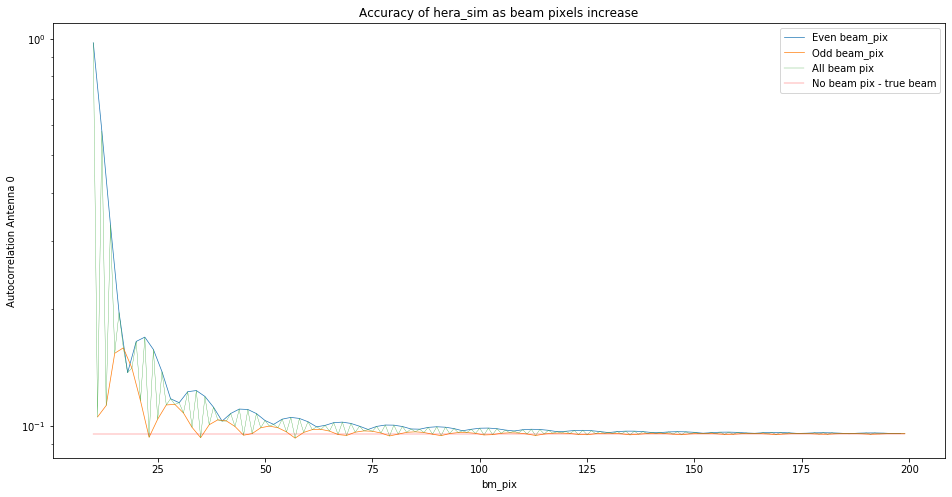

In [3]:
hera_sim_true_value = 0.09513380964848758     # Antenna 0 amplitude if the true beam value is used

pix = []
val = []

for i in range(10, 200):
    uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=2, nfreq=1, ntime=1, nsource=1)
    simulator_cpu = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        bm_pix = i,
        precision = 2
    )

    simulator_cpu.simulate()
    pix.append(i)
    val.append(np.abs(simulator_cpu.uvdata.get_data(0, 0, 'XX')[0][0]))

pix = np.array(pix); val = np.array(val)
plt.xlabel("bm_pix")
plt.ylabel("Autocorrelation Antenna 0")
plt.yscale("log")
plt.plot(pix[pix%2==0], val[pix%2==0], label="Even beam_pix", lw=0.7)
plt.plot(pix[pix%2==1], val[pix%2==1], label="Odd beam_pix", lw=0.7)
plt.plot(pix, val, label="All beam pix", lw=0.3)
plt.plot(pix, np.full(len(pix), hera_sim_true_value), "r", lw=0.3, label="No beam pix - true beam")
plt.title("Accuracy of hera_sim as beam pixels increase")
plt.legend()


The x-axis is the number of beam pixels, the y-axis is logscale, and is the autocorrelation of antenna 0. The flat line is the true autocorrelation value, towards which the other lines converge. The values from pixel beam interpolation oscillate, so increasing from bm_pix=N to bm_pix=N+1 might not give a more accurate value. 

**Percentage error**

I modify the previous plot to plot the percentage difference between the "No beam pix - true beam" line, and the other lines (that are based on using pixel interpolation). This is the error produced by using pixel beams.

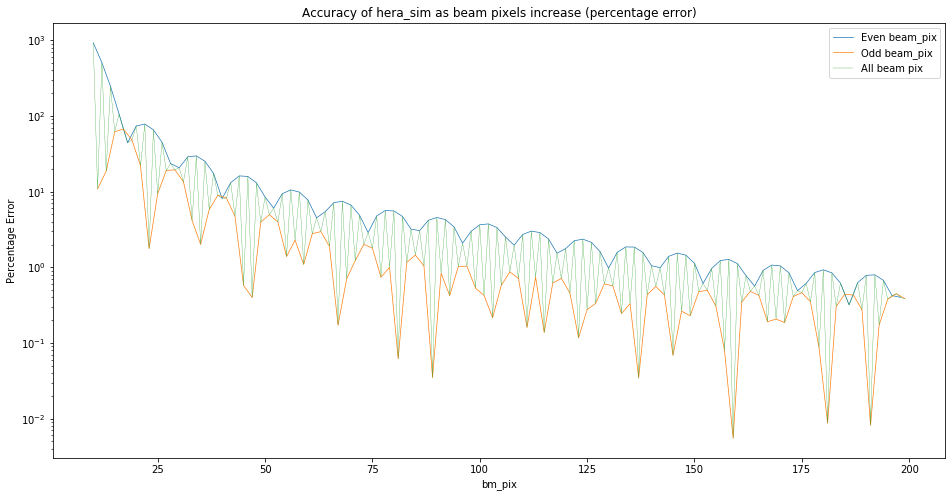

In [4]:
plt.xlabel("bm_pix")
plt.ylabel("Percentage Error")
plt.yscale("log")
plt.plot(pix[pix%2==0], np.abs((val[pix%2==0]-hera_sim_true_value)/hera_sim_true_value*100), label="Even beam_pix", lw=0.7)
plt.plot(pix[pix%2==1], np.abs((val[pix%2==1]-hera_sim_true_value)/hera_sim_true_value*100), label="Odd beam_pix", lw=0.7)
plt.plot(pix, np.abs((val-hera_sim_true_value)/hera_sim_true_value*100), label="All beam pix", lw=0.3)
plt.title("Accuracy of hera_sim as beam pixels increase (percentage error)")
plt.legend()


The error is converging to about 0.4%, but it goes as low as 0.01% for certain bm_pix values. 

**Using a very large number of pixels**

A large number of pixels makes the CPU code very slow, but it doesn't have much impact on GPU speed. Therefore I can use the GPU version to push the number of pixels up to bm_pix=5000, and observe the effect on the accuracy. I only plot the percentage error as bm_pix increases.

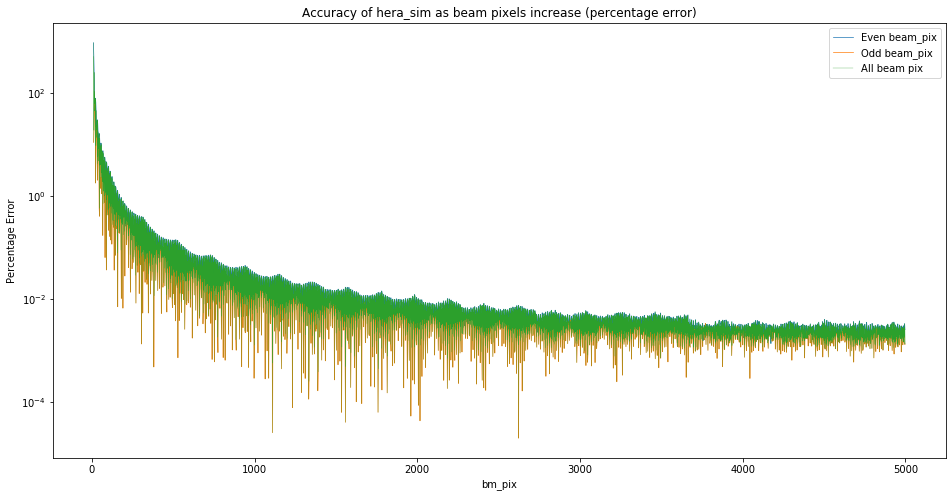

In [11]:
hera_sim_true_value = 0.09513235837221146    # Antenna 0 amplitude if the true beam value is used

pix = []
val = []

for i in range(10, 5000):
    uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=2, nfreq=1, ntime=1, nsource=1)
    simulator_gpu = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        use_gpu = True,
        bm_pix = i,
        precision = 2
    )

    simulator_gpu.simulate()
    pix.append(i)
    val.append(np.abs(simulator_gpu.uvdata.get_data(0, 0, 'XX')[0][0]))

pix = np.array(pix); val = np.array(val)
plt.xlabel("bm_pix")
plt.ylabel("Percentage Error")
plt.yscale("log")
plt.plot(pix[pix%2==0], np.abs((val[pix%2==0]-hera_sim_true_value)/hera_sim_true_value*100), label="Even beam_pix", lw=0.7)
plt.plot(pix[pix%2==1], np.abs((val[pix%2==1]-hera_sim_true_value)/hera_sim_true_value*100), label="Odd beam_pix", lw=0.7)
plt.plot(pix, np.abs((val-hera_sim_true_value)/hera_sim_true_value*100), label="All beam pix", lw=0.3)
plt.title("Accuracy of hera_sim as beam pixels increase (percentage error)")
plt.legend()

As the number of pixels gets large, the error reduces, but slowly. The error at bm_pix=5000 is a bit above 0.01%. It's hard to tell because of the oscillation. 


### hera_sim vs. pyuvsim

The output of hera_sim is not the same as the output of pyuvsim, as demonstrated here. pyuvsim uses different calculations for source locations, which effects the beam value for each source. When I've been referring to the "true" value of the autocorrelation above, that means "true according to hera_sim". The value that is "true according to pyuvsim" could be different.

In the following code I use pyuvsim to simulate the same configuration used for hera_sim, and compare the autocorrelation value for antenna 0.

In [18]:
uvdata, beam, beam_dict, sky_model = telescope_config("pyuvsim", nant=2, nfreq=1, ntime=1, nsource=1)
start = time.time()
pyuvsim_uvd = uvsim.run_uvdata_uvsim(uvdata, BeamList(beam), beam_dict=beam_dict, catalog=simsetup.SkyModelData(sky_model))
print("pyuvsim autocorrelation value antenna 0", pyuvsim_uvd.get_data(0, 0, "XX")[0][0])   # Same location in uvdata as above

Nbls: 3
Ntimes: 1
Nfreqs: 1
Nsrcs: 1
Tasks:  3.0
33.33% completed. 0:00:00.009922  elapsed. 0:00:00.019844 remaining. 

66.67% completed. 0:00:00.010955  elapsed. 0:00:00.005477 remaining. 

100.00% completed. 0:00:00.011378  elapsed. 0:00:00 remaining. 

Calculations Complete.
pyuvsim autocorrelation value antenna 0 (0.0528842029860819+0j)



In the above simulation, pyuvsim splits the source flux equally between XX and YY polarizations, but hera_sim doesn't do this, it puts all the source flux into XX. Therefore, to make a proper comparison, the value from pyuvsim needs to be doubled. That gives:

hera_sim true value: 0.09513235837221146<br>
pyuvsim value: 0.1057684059721638

The values differ by 11%.


## 6. Effect of pixel beams on run time

I configure a larger simulation, and increase the bm_pix to see what effect that has on run time, for CPU and GPU versions. For this simulation I use nant=50, nfreq=50, ntime=50, nsource=50.

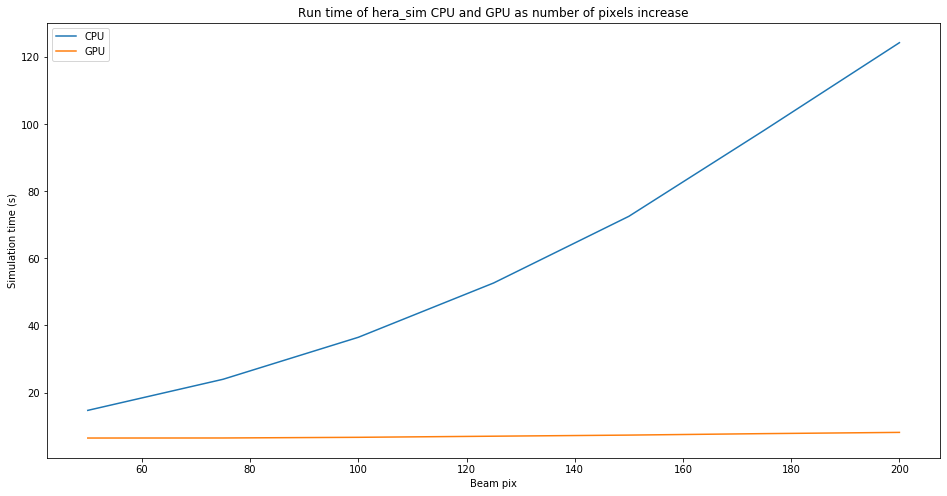

In [22]:
pixs = []
cpu_times = []
gpu_times = []

for pix in [ 50, 75, 100, 125, 150, 175, 200 ]:
    uvdata, beam, beam_dict, freqs, ra_dec, flux = \
        telescope_config("hera_sim", nant=50, nfreq=50, ntime=50, nsource=50)
    
    simulator_cpu = VisCPU (
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        bm_pix = pix,
        precision = 2
    )
    start = time.time()
    simulator_cpu.simulate()
    cpu_time = time.time()-start
    
    uvdata, beam, beam_dict, freqs, ra_dec, flux = \
        telescope_config("hera_sim", nant=50, nfreq=50, ntime=50, nsource=50)
    
    simulator_gpu = VisCPU (
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec.astype(np.float32),
        point_source_flux = flux,
        bm_pix = pix,
        use_gpu = True,
        precision = 2
    )
    start = time.time()
    simulator_gpu.simulate()
    gpu_time = time.time()-start
    
    pixs.append(pix)
    cpu_times.append(cpu_time)
    gpu_times.append(gpu_time)
    
plt.plot(pixs, cpu_times, label="CPU")
plt.plot(pixs, gpu_times, label="GPU")
plt.xlabel("bm_pix")
plt.ylabel("Simulation time (s)")
plt.title("Run time of hera_sim CPU and GPU as number of pixels increase")
plt.legend()

As expected, the CPU run time increases with the bm_pix parameter. The GPU run time does not change, so the bm_pix could be increased until memory runs out, and it should get more accurate, but slowly.